In [1]:
import pandas as pd
import featuretools as ft
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, cross_val_score
import numpy as np
from tpot import TPOTClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import balanced_accuracy_score
import joblib  # 用于保存交互项模式和模型

In [2]:
X_y_group_train = pd.read_csv('mid_data/X_y_group_train_updated_v9.2_PC+ES.csv')

print("Adding numeric labels y")
le = LabelEncoder()
X_y_group_train["y"] = le.fit_transform(X_y_group_train["label"])
# reordering columns:
X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]


blacklist = ["ttest(v,X)", "pvalue(ttest(v,X))<=0.05", "ttest(v,Y)", "pvalue(ttest(v,Y))<=0.05", "ttest(X,Y)", "pvalue(ttest(X,Y))<=0.05"]
columns_to_drop = [col for col in blacklist if col in X_y_group_train.columns]
X_y_group_train = X_y_group_train.drop(columns=columns_to_drop)

numeric_columns = X_y_group_train.select_dtypes(include=[np.number]).columns
X_y_group_train[numeric_columns] = X_y_group_train[numeric_columns].fillna(X_y_group_train[numeric_columns].mean())

display(X_y_group_train)

print("Extracting X_train, y_train, and group")
X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")

y_train = X_y_group_train["y"]
group_train = X_y_group_train["dataset"]

Adding numeric labels y


,dataset,variable,dimension,"corr(v,X)","corr(v,Y)","max(corr(v, others))","min(corr(v, others))","mean(corr(v, others))","std(corr(v, others))","corr(X,Y)",...,"PC(v,Y)","PC(Y,v)","PC(X,Y)","ExactSearch(v,X)","ExactSearch(X,v)","ExactSearch(v,Y)","ExactSearch(Y,v)","ExactSearch(X,Y)",label,y
0,0,0,8,0.169735,-0.113595,0.791467,0.027355,0.282376,0.298969,-0.771058,...,0,0,1,0,0,0,1,1,Consequence of Y,5
1,0,2,8,-0.072334,0.139419,0.230139,0.003233,0.090511,0.082201,-0.771058,...,0,0,1,0,0,0,0,1,Independent,6
2,0,3,8,0.123115,-0.238769,0.781051,0.012225,0.257037,0.288165,-0.771058,...,0,0,1,0,0,1,0,1,Cause of Y,1
3,0,4,8,-0.001935,0.013921,0.147408,0.001935,0.052451,0.053457,-0.771058,...,0,0,1,0,0,0,0,1,Cause of Y,1
4,0,5,8,0.284323,-0.466570,0.791467,0.064815,0.426306,0.250048,-0.771058,...,1,0,1,0,1,0,1,1,Mediator,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142905,46997,6,7,0.014740,0.697089,0.748635,0.013858,0.376630,0.352655,-0.089641,...,0,0,1,0,0,1,0,1,Cause of Y,1
142906,46997,7,7,-0.007397,-0.116481,0.998843,0.007397,0.180741,0.333308,-0.089641,...,0,0,1,0,0,1,0,1,Cause of Y,1
142907,46997,8,7,-0.011658,0.908029,0.970364,0.011658,0.469777,0.441105,-0.089641,...,1,0,1,0,0,1,0,1,Cause of Y,1
142908,46998,0,2,0.083546,-0.019665,0.083546,0.016856,0.040022,0.037719,0.036862,...,0,0,0,0,1,0,0,0,Consequence of X,4


Extracting X_train, y_train, and group


In [3]:
import re

def clean_feature_names(X):
    # 函数用于清理特征名称
    def clean_name(name):
        # 移除或替换特殊字符
        name = re.sub(r'[^\w\s-]', '_', name)
        # 确保名称不以数字开头
        if name[0].isdigit():
            name = 'f_' + name
        return name

    X.columns = [clean_name(col) for col in X.columns]
    return X

# 清理特征名称
X_train = clean_feature_names(X_train)

Best LGBM Pharamter now:
```python
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
```

Score: 0.587x



In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report

from lightgbm import LGBMClassifier
import lightgbm as lgb

class_weights = {0: 10,
                1: 10,
                2: 20,
                3: 15,
                4: 10,
                5: 10,
                6: 10,
                7: 20}

model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29, 
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
display(model)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 定义回调函数
callbacks = [lgb.log_evaluation(period=1), lgb.early_stopping(stopping_rounds=10)]

# 训练模型
model.fit(X_train, y_train, callbacks=callbacks, eval_set=[(X_test, y_test)])

# 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算平衡准确率
train_score = balanced_accuracy_score(y_train, y_train_pred)
test_score = balanced_accuracy_score(y_test, y_test_pred)

print(f"Train balanced accuracy: {train_score:.4f}")
print(f"Test balanced accuracy: {test_score:.4f}")

# 输出详细的分类报告
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, device='gpu',
               gpu_device_id=0, gpu_platform_id=1, learning_rate=0.05,
               max_depth=7, n_estimators=2000, n_jobs=-1, num_leaves=29,
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13298
[LightGBM] [Info] Number of data points in the train set: 114328, number of used features: 64
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: gfx902, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 53 dense feature groups (6.11 MB) transferred to GPU in 0.017275 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from sco

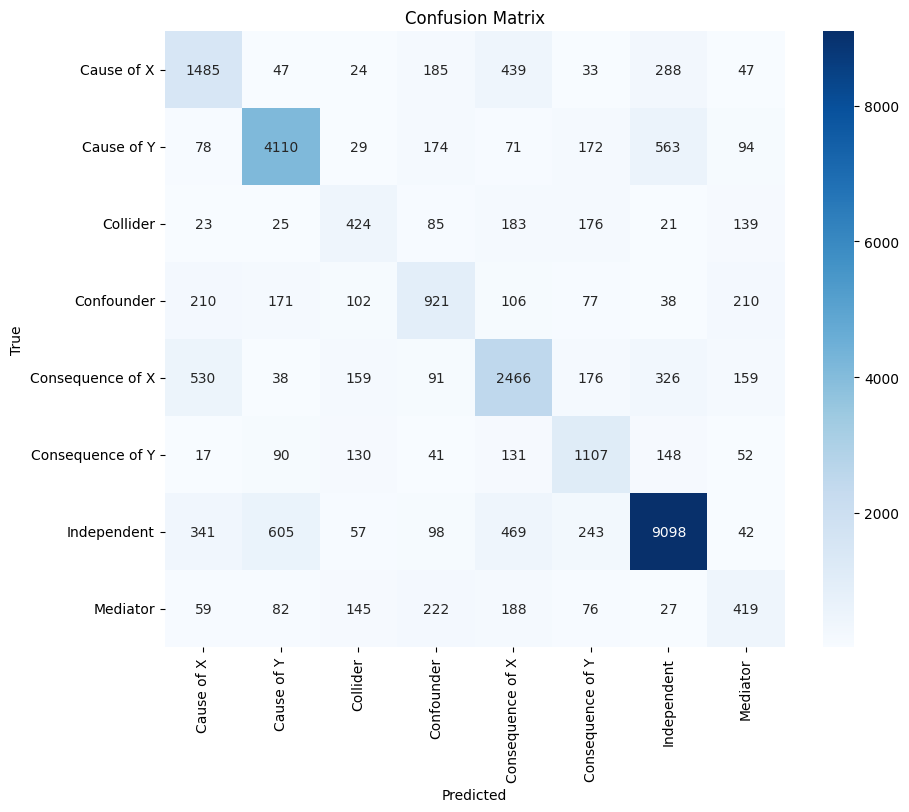

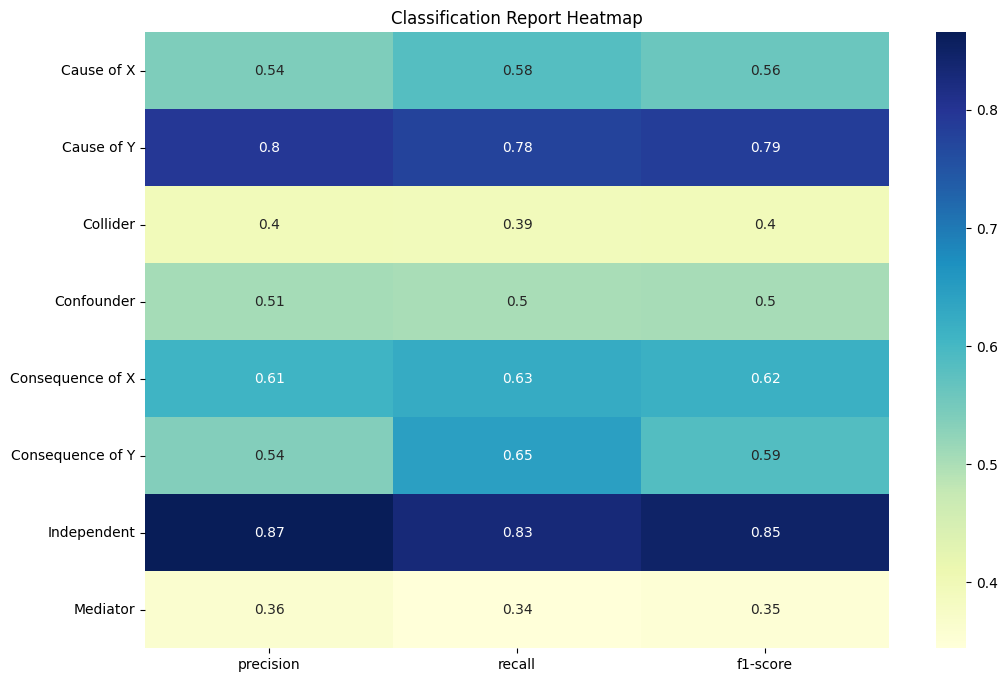

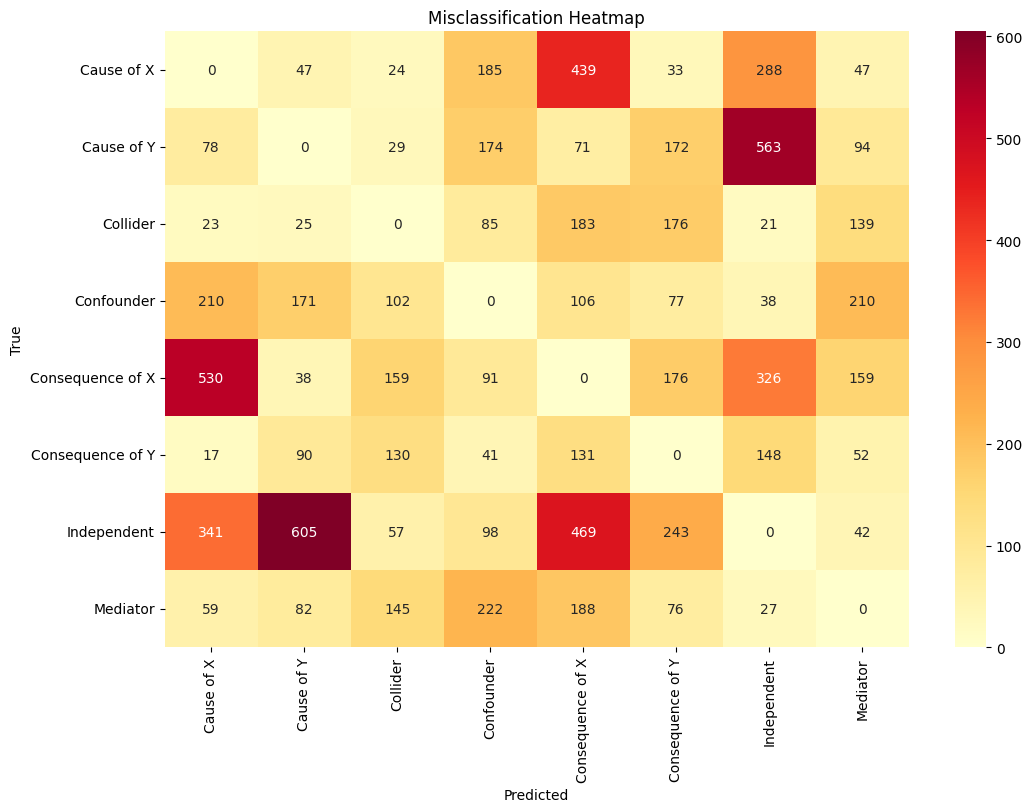

Most common misclassifications:
True              Predicted       
Independent       Cause of Y          605
Cause of Y        Independent         563
Consequence of X  Cause of X          530
Independent       Consequence of X    469
Cause of X        Consequence of X    439
Independent       Cause of X          341
Consequence of X  Independent         326
Cause of X        Independent         288
Independent       Consequence of Y    243
Mediator          Confounder          222
dtype: int64


In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 假设我们已经有了预测结果 y_pred 和真实标签 y_true
# 如果没有,请先运行模型得到预测结果

# 1. 计算混淆矩阵

y_true = y_test
y_pred = y_test_pred

cm = confusion_matrix(y_true, y_pred)

# 2. 创建混淆矩阵热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. 计算每个类别的精确度、召回率和F1分数
report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# 4. 创建分类报告可视化
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(12, 8))
sns.heatmap(df_report.iloc[:-3, :-1].astype(float), annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()

# 5. 分析错误分类情况
misclassified = y_true != y_pred
error_df = pd.DataFrame({
    'True': le.inverse_transform(y_true[misclassified]),
    'Predicted': le.inverse_transform(y_pred[misclassified])
})
error_counts = error_df.groupby(['True', 'Predicted']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(error_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Misclassification Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 打印最常见的错误分类情况
print("Most common misclassifications:")
print(error_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10))

In [7]:
import re

def clean_feature_names(X):
    # 函数用于清理特征名称
    def clean_name(name):
        # 移除或替换特殊字符
        name = re.sub(r'[^\w\s-]', '_', name)
        # 确保名称不以数字开头
        if name[0].isdigit():
            name = 'f_' + name
        return name

    X.columns = [clean_name(col) for col in X.columns]
    return X

# 清理特征名称
X_train_new = clean_feature_names(X_train_new)

In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report

from lightgbm import LGBMClassifier
import lightgbm as lgb
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
display(model)

# 分割数据集
X_train_new, X_test, y_train, y_test = train_test_split(X_train_new, y_train, test_size=0.2, random_state=42)

# 定义回调函数
callbacks = [lgb.log_evaluation(period=1), lgb.early_stopping(stopping_rounds=10)]

# 训练模型
model.fit(X_train_new, y_train, callbacks=callbacks, eval_set=[(X_test, y_test)])

# 预测
y_train_pred = model.predict(X_train_new)
y_test_pred = model.predict(X_test)

# 计算平衡准确率
train_score = balanced_accuracy_score(y_train, y_train_pred)
test_score = balanced_accuracy_score(y_test, y_test_pred)

print(f"Train balanced accuracy: {train_score:.4f}")
print(f"Test balanced accuracy: {test_score:.4f}")

# 输出详细的分类报告
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, device='gpu',
               gpu_device_id=0, gpu_platform_id=1, learning_rate=0.05,
               max_depth=7, n_estimators=2000, n_jobs=-1, num_leaves=29,
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24753
[LightGBM] [Info] Number of data points in the train set: 46828, number of used features: 99
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: gfx902, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 97 dense feature groups (4.47 MB) transferred to GPU in 0.011556 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from scor